# Exploratory Data Analysis 2

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest

# Data Loading and Missing Value Handling

In [12]:
# Load the dataset
df = pd.read_csv('adult_with_headers.csv')

# Handle missing values (represented as ' ?') by replacing with NaN
# Note: ' ?' is used because of the leading space in the raw data
df = df.replace(' ?', np.nan)

# Imputation for object columns with missing values: fill with the mode
for col in ['workclass', 'occupation', 'native_country']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Clean up spaces in categorical columns for consistent encoding
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

/tmp/ipython-input-589763582.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


# Feature Engineering

In [13]:
# New Feature 1: Capital_Net
df['Capital_Net'] = df['capital_gain'] - df['capital_loss']

# New Feature 2: Work_Load_Score (hours_per_week * education_num)
df['Work_Load_Score'] = df['hours_per_week'] * df['education_num']

# Transformation: Log transformation on highly skewed capital_gain
# Using np.log1p (log(1+x)) to handle zero values
df['capital_gain_Log'] = np.log1p(df['capital_gain'])

# Scaling and Encoding

In [14]:
numerical_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
new_numerical_cols = ['Capital_Net', 'Work_Load_Score', 'capital_gain_Log']
all_numerical_cols = numerical_cols + new_numerical_cols
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('income')

# Initialize Scaler
scaler = StandardScaler()

# Apply Standard Scaling to all numerical features
df_scaled = pd.DataFrame(scaler.fit_transform(df[all_numerical_cols]),
                         columns=[col + '_Standard' for col in all_numerical_cols])

# Concatenate scaled features with the original DataFrame (dropping original numerical columns)
df_processed = pd.concat([df.drop(columns=all_numerical_cols), df_scaled], axis=1)

# Target variable mapping (Binary Encoding)
df_processed['income_encoded'] = df_processed['income'].map({'<=50K': 0, '>50K': 1})
df_processed.drop('income', axis=1, inplace=True)

# Encoding Logic (OHE for < 5 categories, LE for >= 5 categories)
ohe_cols = [col for col in categorical_cols if df_processed[col].nunique() < 5]
le_cols = [col for col in categorical_cols if df_processed[col].nunique() >= 5]

# Apply One-Hot Encoding (OHE)
df_processed = pd.get_dummies(df_processed, columns=ohe_cols, prefix=ohe_cols, drop_first=True)

# Apply Label Encoding (LE)
le = LabelEncoder()
for col in le_cols:
    df_processed[col + '_encoded'] = le.fit_transform(df_processed[col])
    df_processed.drop(col, axis=1, inplace=True)

# Feature Selection: Outlier Removal (Isolation Forest)

In [15]:
# Exclude target variable
X = df_processed.drop('income_encoded', axis=1)

# Initialize Isolation Forest (using 5% contamination)
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit and predict. -1 indicates outliers, 1 indicates inliers
outlier_predictions = iso_forest.fit_predict(X)

# Filter the DataFrame to keep only inliers
df_final = df_processed[outlier_predictions == 1].copy()

print(f"Final Data Size (after outlier removal): {len(df_final)}")
print("\nFinal Processed Data (Head):")
print(df_final.head())

Final Data Size (after outlier removal): 30933

Final Processed Data (Head):
   age_Standard  fnlwgt_Standard  education_num_Standard  \
0      0.030671        -1.063611                1.134739   
1      0.837109        -1.008707                1.134739   
2     -0.042642         0.245079               -0.420060   
3      1.057047         0.425801               -1.197459   
5     -0.115955         0.898201                1.523438   

   capital_gain_Standard  capital_loss_Standard  hours_per_week_Standard  \
0               0.148453               -0.21666                -0.035429   
1              -0.145920               -0.21666                -2.222153   
2              -0.145920               -0.21666                -0.035429   
3              -0.145920               -0.21666                -0.035429   
5              -0.145920               -0.21666                -0.035429   

   Capital_Net_Standard  Work_Load_Score_Standard  capital_gain_Log_Standard  \
0              0.159762  

In [16]:
# 1. Calculate Correlation Matrix
correlation_cols = df_inliers.select_dtypes(include=['float64', 'int64']).columns.tolist()
corr_matrix = df_inliers[correlation_cols].corr()

# 2. Print Key Correlations with Target (Income)
print("Top 5 Positive Correlations with Income (Target):")
print(corr_matrix['income_encoded'].sort_values(ascending=False).head(6).iloc[1:]) # Start from index 1 to exclude income_encoded itself
print("\nTop 5 Negative Correlations with Income (Target):")
print(corr_matrix['income_encoded'].sort_values(ascending=True).head(5))



Top 5 Positive Correlations with Income (Target):
Work_Load_Score_Standard    0.351396
education_num_Standard      0.310254
capital_gain_Standard       0.240825
age_Standard                0.229578
hours_per_week_Standard     0.218045
Name: income_encoded, dtype: float64

Top 5 Negative Correlations with Income (Target):
relationship_encoded     -0.269354
marital_status_encoded   -0.197165
fnlwgt_Standard          -0.013392
workclass_encoded        -0.008492
occupation_encoded        0.030156
Name: income_encoded, dtype: float64


# Visualize Correlation Matrix

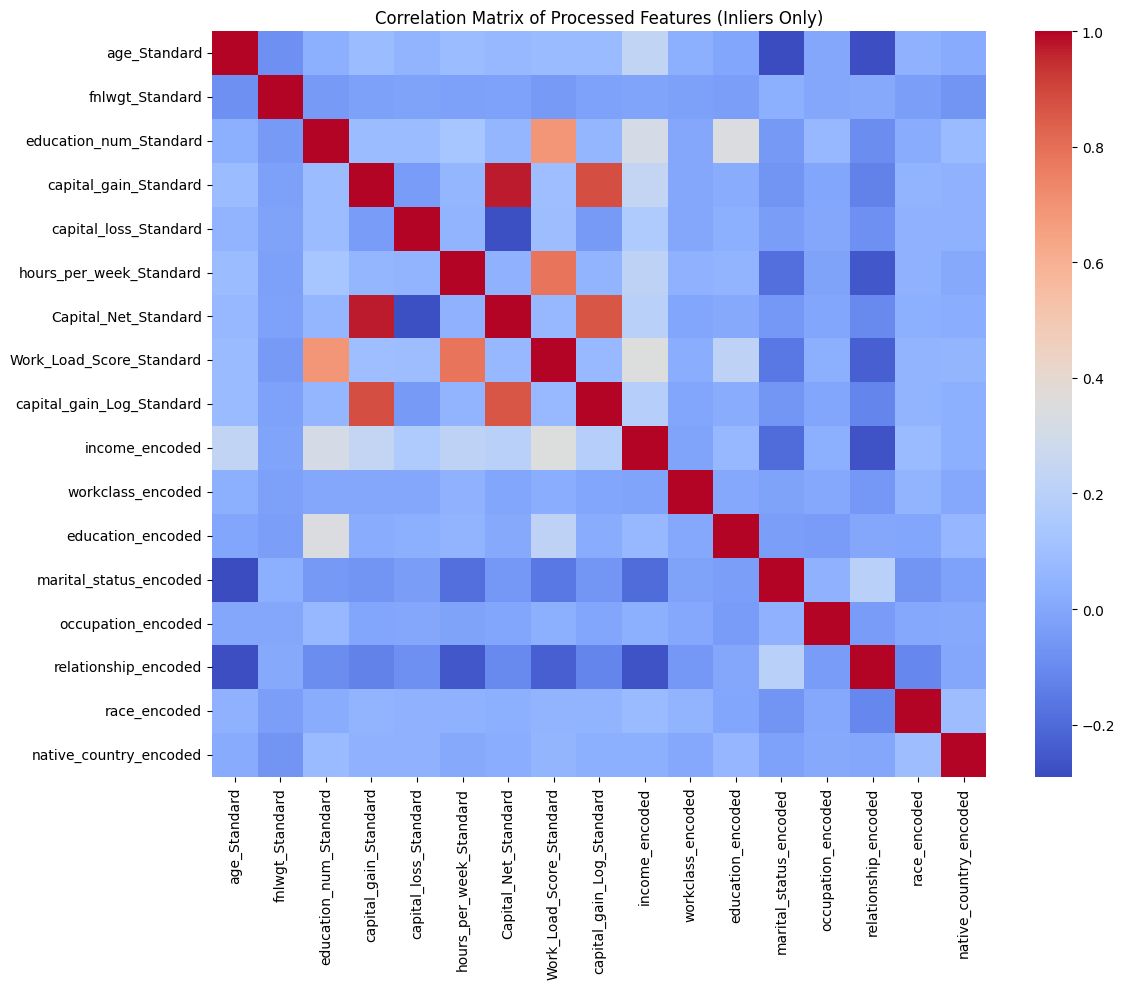

In [17]:
# 3. Visualize Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Processed Features (Inliers Only)')
plt.tight_layout()
plt.savefig('correlation_matrix_final.png')
plt.show()

# Conclusion
The core steps involved Mode Imputation to handle missing categorical values and Standard Scaling to normalize all numerical features. Feature Engineering added significant predictive value by creating the Capital_Net income proxy and applying a Log Transformation to correct the extreme skewness of capital_gain. Finally, categorical data was converted using both One-Hot and Label Encoding, and Isolation Forest was utilized to remove 5% of outliers, resulting in a clean, optimized dataset for high-performance classification models.